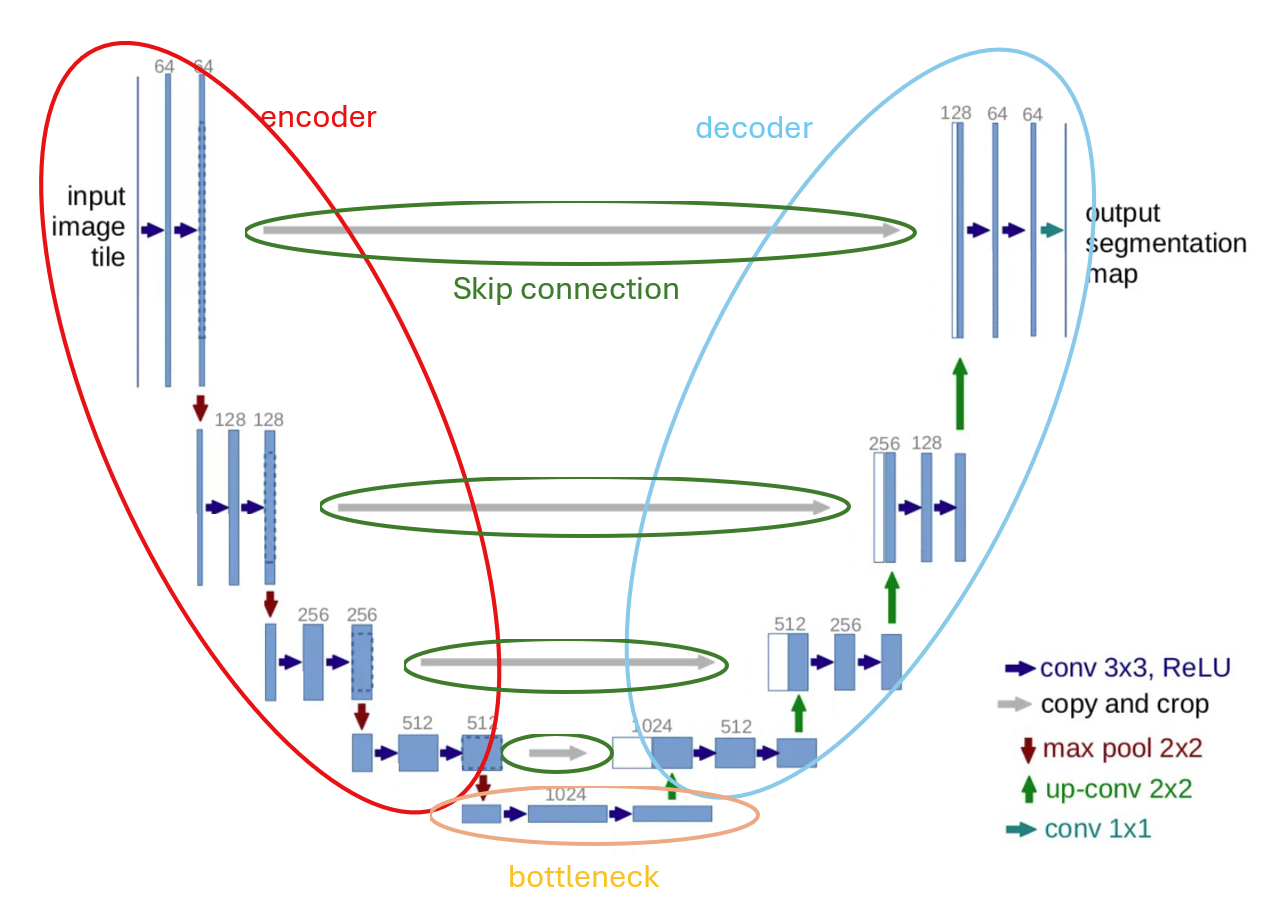

In [2]:
# Build one of the main components - DoubleConv - for UNet
# DoubleConv block = (Conv → BN → ReLU) × 2
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        # nn.Sequential groups layers together so they run in order
        self.conv = nn.Sequential(
            # First convolution: from in_channels → out_channels
            # kernel_size=3, stride=1, padding=1 → keeps spatial size the same ("same padding")
            # bias=False because BatchNorm already has a bias term
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            
            # Batch Normalization: normalizes activations, speeds up convergence, improves stability
            nn.BatchNorm2d(out_channels),
            
            # ReLU activation: adds non-linearity
            # inplace=True saves GPU memory by overwriting the input tensor directly
            nn.ReLU(inplace=True),
            
            # Second convolution: another 3×3 conv to extract richer features
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            
            # Another Batch Normalization
            nn.BatchNorm2d(out_channels),
            
            # Another ReLU
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Input x passes sequentially through (Conv → BN → ReLU) × 2
        return self.conv(x)

In [3]:
# Build UNet from scratch
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Encoder: store downsampling blocks
        self.encoder = nn.ModuleList()
        # Decoder: store upsampling blocks
        self.decoder = nn.ModuleList()

        # ---------------------------
        # Encoder path (downsampling)
        # ---------------------------
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature  # update for next block

        # Bottleneck (deepest features)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # ---------------------------
        # Decoder path (upsampling)
        # ---------------------------
        for feature in reversed(features):
            # Upsample spatially
            self.decoder.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            # Refine features after concatenation with skip connection
            self.decoder.append(DoubleConv(feature*2, feature))

        # Final 1×1 conv to map to desired output channels
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # ---------------------------
        # Encoder forward pass
        # Save skip connections for decoder
        # ---------------------------
        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)  # downsample

        # ---------------------------
        # Bottleneck
        # ---------------------------
        x = self.bottleneck(x)

        # Reverse skip connections to match decoder order
        skip_connections = skip_connections[::-1]

        # ---------------------------
        # Decoder forward pass
        # ---------------------------
        for i in range(0, len(self.decoder), 2):
            x = self.decoder[i](x)                         # ConvTranspose2d (upsample)
            skip_connection = skip_connections[i//2]       # corresponding encoder skip
            concat = torch.cat((skip_connection, x), dim=1) # concatenate channels
            x = self.decoder[i+1](concat)                  # refine with DoubleConv

        # ---------------------------
        # Output layer
        # ---------------------------
        return self.final_conv(x)
        

In [4]:
# Create an UNet model object
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
print(summary(model, input_size = (3, 512, 512), batch_size = 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 512, 512]           1,728
       BatchNorm2d-2          [4, 64, 512, 512]             128
              ReLU-3          [4, 64, 512, 512]               0
            Conv2d-4          [4, 64, 512, 512]          36,864
       BatchNorm2d-5          [4, 64, 512, 512]             128
              ReLU-6          [4, 64, 512, 512]               0
        DoubleConv-7          [4, 64, 512, 512]               0
            Conv2d-8         [4, 128, 256, 256]          73,728
       BatchNorm2d-9         [4, 128, 256, 256]             256
             ReLU-10         [4, 128, 256, 256]               0
           Conv2d-11         [4, 128, 256, 256]         147,456
      BatchNorm2d-12         [4, 128, 256, 256]             256
             ReLU-13         [4, 128, 256, 256]               0
       DoubleConv-14         [4, 128, 2